In [1]:
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
from simple_vector_db.quantization.vector_quantizer import VectorQuantizer
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_digits
import pandas as pd
import psutil
import numpy as np
import sys
import seaborn as sns
import dataget
import random

/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
def load_fashion_mnist(n_sample=1000):
    X_train, y_train, X_test, y_test = dataget.image.fashion_mnist().get()
    X = np.vstack([X_train, X_test])
    images = []
    for image in X:
        images.append(image.flatten())
    random.shuffle(images)
    images = images[0:n_sample]
    return images

In [4]:

import numpy as np

def taille_memoire(entier):
    if np.iinfo(np.int8).min <= entier <= np.iinfo(np.int8).max:
        return np.dtype(np.int8).itemsize
    elif np.iinfo(np.int16).min <= entier <= np.iinfo(np.int16).max:
        return np.dtype(np.int16).itemsize
    elif np.iinfo(np.int32).min <= entier <= np.iinfo(np.int32).max:
        return np.dtype(np.int32).itemsize
    elif np.iinfo(np.int64).min <= entier <= np.iinfo(np.int64).max:
        return np.dtype(np.int64).itemsize
    else:
        return None


taille_memoire(9000000)

4

In [5]:
vectors_to_quantize = load_digits().data
#vectors_to_quantize = load_fashion_mnist()

In [17]:
m_chunks_list = list(range(4, 64,4))
res = []
for m_chunk in [2]+m_chunks_list:
    k_centroids_list = np.array(range(10, 500,25))
    for k_centroids in k_centroids_list:
        try:
            quantizer = VectorQuantizer(m_chunks=m_chunk, nb_subspace_centroids=k_centroids)
            quantized_vectors = quantizer.quantize_vectors(vectors_to_quantize)
            #print(m_chunk, k_centroids, (vectors_to_quantize.size * vectors_to_quantize.itemsize) / 1024,
            #      (quantized_vectors.size * quantized_vectors.itemsize) / 1024)
            rebuilt_vector = quantizer.rebuild_vector(quantized_vectors[0])
            compression_mse = mean_squared_error(vectors_to_quantize[0], rebuilt_vector)
            res.append(
                {"Nombre de sections": m_chunk, "Nombre de centroïdes par section": k_centroids,
                 "mesure MSE": compression_mse,
                 "mémoire en kB": (len(quantized_vectors) * m_chunk * taille_memoire(k_centroids)) / 1024})
        except ValueError:
            print(m_chunk, k_centroids, "ERROR")
        res_df = pd.DataFrame(res)
        res_df.to_csv("../figures/quantization_mse_vs_params_FMNIST.csv")


2023-12-08 21:16:18,639 - ERROR - The vector's dimension 64 is not divisible by 12 - (vector_quantizer.py:44)
12 10 ERROR
2023-12-08 21:16:18,671 - ERROR - The vector's dimension 64 is not divisible by 12 - (vector_quantizer.py:44)
12 35 ERROR
2023-12-08 21:16:18,696 - ERROR - The vector's dimension 64 is not divisible by 12 - (vector_quantizer.py:44)
12 60 ERROR
2023-12-08 21:16:18,736 - ERROR - The vector's dimension 64 is not divisible by 12 - (vector_quantizer.py:44)
12 85 ERROR
2023-12-08 21:16:18,742 - ERROR - The vector's dimension 64 is not divisible by 12 - (vector_quantizer.py:44)
12 110 ERROR
2023-12-08 21:16:18,745 - ERROR - The vector's dimension 64 is not divisible by 12 - (vector_quantizer.py:44)
12 135 ERROR
2023-12-08 21:16:18,749 - ERROR - The vector's dimension 64 is not divisible by 12 - (vector_quantizer.py:44)
12 160 ERROR
2023-12-08 21:16:18,755 - ERROR - The vector's dimension 64 is not divisible by 12 - (vector_quantizer.py:44)
12 185 ERROR
2023-12-08 21:16:18,

/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (272) found smaller than n_clusters (285). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (262) found smaller than n_clusters (285). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (272) found smaller than n_clusters (310). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/

2023-12-08 21:16:30,293 - ERROR - The vector's dimension 64 is not divisible by 20 - (vector_quantizer.py:44)
20 10 ERROR
2023-12-08 21:16:30,299 - ERROR - The vector's dimension 64 is not divisible by 20 - (vector_quantizer.py:44)
20 35 ERROR
2023-12-08 21:16:30,303 - ERROR - The vector's dimension 64 is not divisible by 20 - (vector_quantizer.py:44)
20 60 ERROR
2023-12-08 21:16:30,307 - ERROR - The vector's dimension 64 is not divisible by 20 - (vector_quantizer.py:44)
20 85 ERROR
2023-12-08 21:16:30,310 - ERROR - The vector's dimension 64 is not divisible by 20 - (vector_quantizer.py:44)
20 110 ERROR
2023-12-08 21:16:30,313 - ERROR - The vector's dimension 64 is not divisible by 20 - (vector_quantizer.py:44)
20 135 ERROR
2023-12-08 21:16:30,315 - ERROR - The vector's dimension 64 is not divisible by 20 - (vector_quantizer.py:44)
20 160 ERROR
2023-12-08 21:16:30,318 - ERROR - The vector's dimension 64 is not divisible by 20 - (vector_quantizer.py:44)
20 185 ERROR
2023-12-08 21:16:30,

/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (262) found smaller than n_clusters (485). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (439) found smaller than n_clusters (485). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


28 60 ERROR
2023-12-08 21:16:30,445 - ERROR - The vector's dimension 64 is not divisible by 28 - (vector_quantizer.py:44)
28 85 ERROR
2023-12-08 21:16:30,449 - ERROR - The vector's dimension 64 is not divisible by 28 - (vector_quantizer.py:44)
28 110 ERROR
2023-12-08 21:16:30,453 - ERROR - The vector's dimension 64 is not divisible by 28 - (vector_quantizer.py:44)
28 135 ERROR
2023-12-08 21:16:30,456 - ERROR - The vector's dimension 64 is not divisible by 28 - (vector_quantizer.py:44)
28 160 ERROR
2023-12-08 21:16:30,461 - ERROR - The vector's dimension 64 is not divisible by 28 - (vector_quantizer.py:44)
28 185 ERROR
2023-12-08 21:16:30,464 - ERROR - The vector's dimension 64 is not divisible by 28 - (vector_quantizer.py:44)
28 210 ERROR
2023-12-08 21:16:30,469 - ERROR - The vector's dimension 64 is not divisible by 28 - (vector_quantizer.py:44)
28 235 ERROR
2023-12-08 21:16:30,474 - ERROR - The vector's dimension 64 is not divisible by 28 - (vector_quantizer.py:44)
28 260 ERROR
2023-

/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (35). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (22) found smaller than n_clusters (35). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/

2023-12-08 21:17:15,633 - ERROR - The vector's dimension 64 is not divisible by 36 - (vector_quantizer.py:44)
36 10 ERROR
2023-12-08 21:17:15,639 - ERROR - The vector's dimension 64 is not divisible by 36 - (vector_quantizer.py:44)
36 35 ERROR
2023-12-08 21:17:15,642 - ERROR - The vector's dimension 64 is not divisible by 36 - (vector_quantizer.py:44)
36 60 ERROR
2023-12-08 21:17:15,645 - ERROR - The vector's dimension 64 is not divisible by 36 - (vector_quantizer.py:44)
36 85 ERROR
2023-12-08 21:17:15,648 - ERROR - The vector's dimension 64 is not divisible by 36 - (vector_quantizer.py:44)
36 110 ERROR
2023-12-08 21:17:15,651 - ERROR - The vector's dimension 64 is not divisible by 36 - (vector_quantizer.py:44)
36 135 ERROR
2023-12-08 21:17:15,654 - ERROR - The vector's dimension 64 is not divisible by 36 - (vector_quantizer.py:44)
36 160 ERROR
2023-12-08 21:17:15,657 - ERROR - The vector's dimension 64 is not divisible by 36 - (vector_quantizer.py:44)
36 185 ERROR
2023-12-08 21:17:15,

/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (167) found smaller than n_clusters (485). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/philippe.stepniewski/Library/Caches/pypoetry/virtualenvs/simple-vector-db-pCRDTAKr-py3.9/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (65) found smaller than n_clusters (485). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


44 185 ERROR
2023-12-08 21:17:15,779 - ERROR - The vector's dimension 64 is not divisible by 44 - (vector_quantizer.py:44)
44 210 ERROR
2023-12-08 21:17:15,782 - ERROR - The vector's dimension 64 is not divisible by 44 - (vector_quantizer.py:44)
44 235 ERROR
2023-12-08 21:17:15,785 - ERROR - The vector's dimension 64 is not divisible by 44 - (vector_quantizer.py:44)
44 260 ERROR
2023-12-08 21:17:15,788 - ERROR - The vector's dimension 64 is not divisible by 44 - (vector_quantizer.py:44)
44 285 ERROR
2023-12-08 21:17:15,791 - ERROR - The vector's dimension 64 is not divisible by 44 - (vector_quantizer.py:44)
44 310 ERROR
2023-12-08 21:17:15,794 - ERROR - The vector's dimension 64 is not divisible by 44 - (vector_quantizer.py:44)
44 335 ERROR
2023-12-08 21:17:15,796 - ERROR - The vector's dimension 64 is not divisible by 44 - (vector_quantizer.py:44)
44 360 ERROR
2023-12-08 21:17:15,799 - ERROR - The vector's dimension 64 is not divisible by 44 - (vector_quantizer.py:44)
44 385 ERROR
202

In [14]:
colors = ["#EE0023", "#0E2356", "#00AD00", "#00A3BE", "#00A795", "#FFE300", "#FF6200", "#9A78F0", "#9FA7BB", "#F899A7"]
custom_palette = sns.color_palette(colors)

/var/folders/6f/tzp_vm_s0g53_39ds1grlmsm0000gn/T/ipykernel_56093/3164529325.py:1: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns_plot = sns.scatterplot(data=res_df, x="Nombre de centroïdes par section", y="mesure MSE", hue="Nombre de sections",


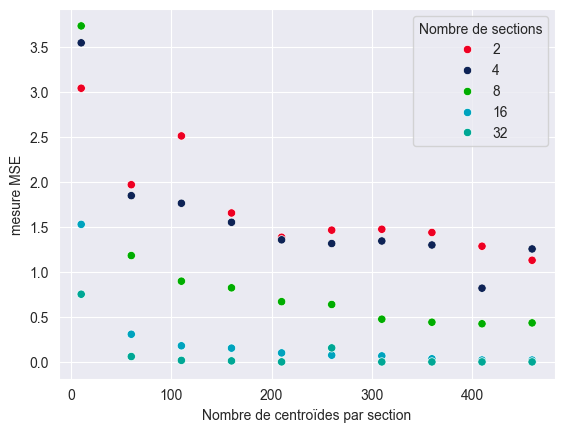

In [15]:
sns_plot = sns.scatterplot(data=res_df, x="Nombre de centroïdes par section", y="mesure MSE", hue="Nombre de sections",
                           palette=custom_palette)
fig = sns_plot.get_figure()
fig.savefig("../figures/mse_vs_params.png")

/var/folders/6f/tzp_vm_s0g53_39ds1grlmsm0000gn/T/ipykernel_56093/1337377132.py:1: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns_plot = sns.scatterplot(data=res_df, x="Nombre de centroïdes par section", y="mémoire en kB", hue="Nombre de sections",


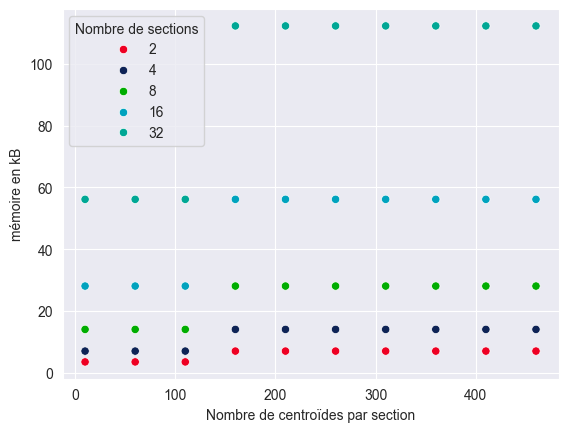

In [16]:
sns_plot = sns.scatterplot(data=res_df, x="Nombre de centroïdes par section", y="mémoire en kB", hue="Nombre de sections",
                           palette=custom_palette)
fig = sns_plot.get_figure()
fig.savefig("../figures/memory_vs_params.png")

## PQ parameters vs Recall 

In [ ]:
bench_kmeans = pd.read_csv("../figures/bench_results_pq.csv")
sns_plot = sns.scatterplot(data=bench_kmeans, y="Nombre de centroïdes par section", x="rappel @ 10",
                           hue="Nombre de sections",
                           palette=custom_palette)
fig = sns_plot.get_figure()
fig.savefig("../figures/pq_recall_vs_params.png")

## PQ RECALL VS SPEED

In [ ]:
bench_kmeans.groupby("rappel @ 10").agg({"nb_requests_per_second": "mean"})

In [ ]:

sns_plot = sns.scatterplot(data=bench_kmeans, x="rappel @ 10", y="Nombre de requêtes par seconde",
                           palette=custom_palette, hue="Nombre de sections")
fig = sns_plot.get_figure()
fig.savefig("../figures/pq_recall_vs_speed.png")

In [ ]:

sns_plot = sns.scatterplot(data=bench_kmeans, x="rappel @ 10", y="Nombre de requêtes par seconde",
                           palette=custom_palette, hue="Nombre de centroïdes par section")
fig = sns_plot.get_figure()
fig.savefig("../figures/pq_recall_vs_speed.png")

## IVKMEANS parameters vs Recall 

In [ ]:
bench_kmeans = pd.read_csv("../figures/bench_results_kmeans.csv")
sns_plot = sns.scatterplot(data=bench_kmeans, y="Nombre de clusters", x="Rappel @ 10",
                           hue="Valeur de n_probes",
                           palette=custom_palette)
fig = sns_plot.get_figure()
fig.savefig("../figures/kmeans_recall_vs_params.png")

In [ ]:
sns_plot = sns.scatterplot(data=bench_kmeans, x="Rappel @ 10", y="Nombre de requêtes par seconde",
                           palette=custom_palette, hue="Valeur de n_probes")
fig = sns_plot.get_figure()
fig.savefig("../figures/kmeans_recall_vs_speed_clusters_nprobs.png")

In [ ]:
bench_kmeans['Intervalle du nombre de clusters '] = pd.cut(bench_kmeans["Nombre de clusters"], bins=5, precision=0)

In [ ]:
sns_plot = sns.scatterplot(data=bench_kmeans, x="Rappel @ 10", y="Nombre de requêtes par seconde",
                           palette=custom_palette, hue='Intervalle du nombre de clusters ')
fig = sns_plot.get_figure()
fig.savefig("../figures/kmeans_recall_vs_speed_clusters.png")

In [ ]:

sns_plot = sns.scatterplot(data=bench_kmeans, x="Rappel @ 10", y="Nombre de requêtes par seconde",
                           palette=custom_palette, hue='Intervalle du nombre de clusters ')
fig = sns_plot.get_figure()
fig.savefig("../figures/kmeans_recall_vs_speed_clusters.png")